# Time Series Classification and Clustering Assignment

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

### Import the Walmart stock price data set (WMT_data.csv).

In [2]:
data = pd.read_csv("https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Time%20Series%20Analysis/Time%20Series%20-%20Day%205/WMT_data.csv")
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,71.20,71.64,71.070,71.48,5906823,WMT
1,2013-02-11,71.25,71.51,70.530,71.40,6202534,WMT
2,2013-02-12,71.49,71.66,71.100,71.40,4761910,WMT
3,2013-02-13,71.29,71.70,71.210,71.39,3969807,WMT
4,2013-02-14,71.10,71.23,70.755,70.82,6820952,WMT


In [3]:
data.date = pd.to_datetime(data.date)
data = data[["date", "close"]]
data.columns = ["Date", "Observed"]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1259 non-null   datetime64[ns]
 1   Observed  1259 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB


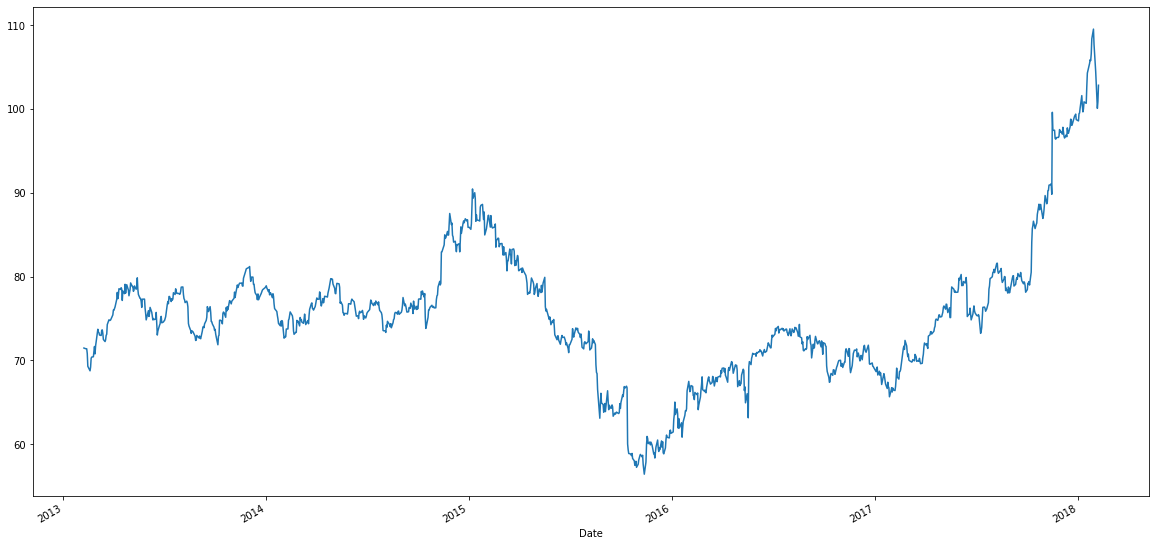

In [4]:
data.set_index('Date')['Observed'].plot(kind='line', figsize=(20,10))

### Transform the data to be able to predict minor direction changes in the stock's price, given 180 days of history.

- Remember to calculate daily returns from the observed values (closing price).
- Make the critera for identifying a direction change when the observed values (closing price) cross the 5 day moving average.
- Create a binary column that defaults to 0 unless the criteria is met (then updates to 1).
- Shift the data set so that you have 180 days of history for each record.

In [5]:
# daily returns from observed values
data['Returns'] = data['Observed'].pct_change()

# 5-day moving avg
data['MA_5'] = data['Observed'].rolling(5).mean()

# trend identification
data['Trend'] = 'None'
data.loc[(data['MA_5'] < data['Observed']), 'Trend'] = 'Negative'
data.loc[(data['MA_5'] > data['Observed']), 'Trend'] = 'Positive'

# binary column for criteria
data['Change'] = data['Trend'].eq(data['Trend'].shift())
data['Binary'] = 0
data.loc[(data['Change']==False) & (data['Trend'] != 'None'), 'Binary'] = 1
data.dropna(inplace=True)

# shifting the dataset to have 180 days of history for each record
transformed = data[['Date', 'Returns', 'Binary']]

history = 180
future = 0

shifts = [x + future for x in list(range(1, history + 1))]

for shift in shifts:
    transformed['t-' + str(shift)] = transformed['Returns'].shift(shift)

transformed.dropna(inplace=True)
transformed.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Returns,Binary,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22,t-23,t-24,t-25,t-26,t-27,t-28,t-29,t-30,t-31,t-32,t-33,t-34,t-35,t-36,t-37,...,t-141,t-142,t-143,t-144,t-145,t-146,t-147,t-148,t-149,t-150,t-151,t-152,t-153,t-154,t-155,t-156,t-157,t-158,t-159,t-160,t-161,t-162,t-163,t-164,t-165,t-166,t-167,t-168,t-169,t-170,t-171,t-172,t-173,t-174,t-175,t-176,t-177,t-178,t-179,t-180
184,2013-10-31,-0.002080,1,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,-0.001891,0.001217,0.006122,...,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463,-0.007984
185,2013-11-01,0.004169,1,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,-0.001891,0.001217,...,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463
186,2013-11-04,0.003374,0,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,-0.001891,...,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792
187,2013-11-05,0.001164,0,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,...,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545
188,2013-11-06,0.009558,0,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,...,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.00013

### Train a Logistic Regression classification model on the transformed data.

In [6]:
# train-test split at 20% with no shuffling
x = transformed.drop(['Date', 'Returns', 'Binary'], axis=1)
y = transformed['Binary']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, shuffle=False)

In [7]:
lr_model = LogisticRegression(class_weight="balanced")
lr_model.fit(x_train, y_train)
lr_pred = lr_model.predict(x_test)

### Run a classification report and evaluate the performance of the classifier.

In [8]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.78      0.63      0.70       161
           1       0.30      0.46      0.36        54

    accuracy                           0.59       215
   macro avg       0.54      0.55      0.53       215
weighted avg       0.66      0.59      0.61       215



### Transform the data again to have 10 days of history for clustering.

In [9]:
ten_days = data[['Date', 'Returns', 'Binary']]

history = 10
future = 0

shifts = [x + future for x in list(range(1, history + 1))]

for shift in shifts:
    ten_days['t-' + str(shift)] = ten_days['Returns'].shift(shift)

ten_days.dropna(inplace=True)
ten_days.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Date,Returns,Binary,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
14,2013-03-01,0.013563,1,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463,-0.007984
15,2013-03-04,0.021188,0,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463
16,2013-03-05,0.006279,0,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792
17,2013-03-06,-0.004612,0,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545
18,2013-03-07,-0.000818,0,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171


### Train a K Means clustering model on the data. 

Try different values for K and see how the summary changes.

In [10]:
def kmeans(df, clusters=2):
    model = KMeans(n_clusters=clusters, random_state=42)
    clusters = model.fit_predict(df)
    results = df.copy()
    results['Cluster'] = clusters
    
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    
    return results, summary

results_2, summary_2 = kmeans(x, clusters=2)
results_4, summary_4 = kmeans(x, clusters=4)
results_6, summary_6 = kmeans(x, clusters=6)
results_8, summary_8 = kmeans(x, clusters=8)
results_10, summary_10 = kmeans(x, clusters=10)

### Visualize the summary of the clustering results as a heatmap.

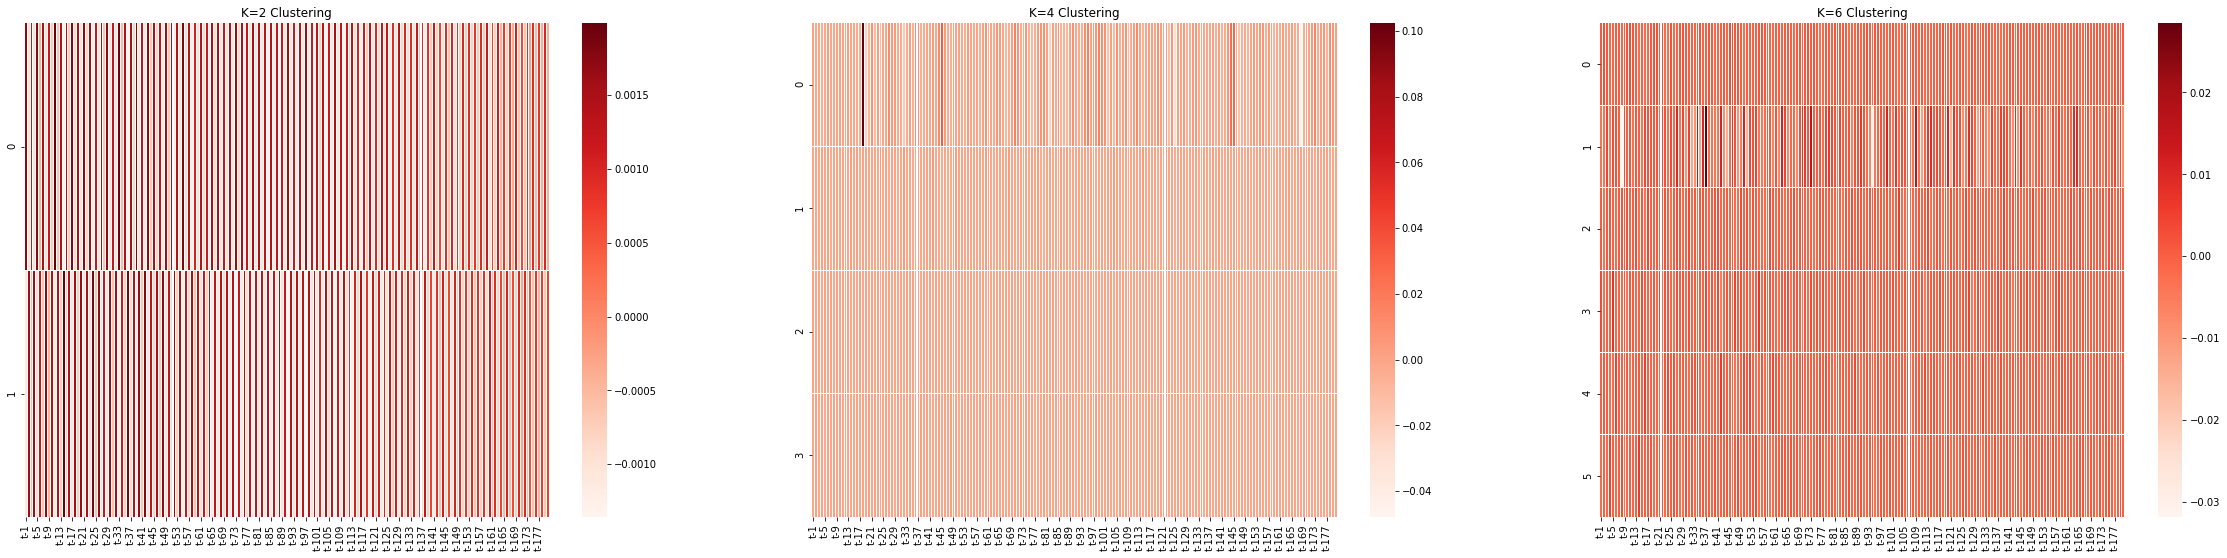

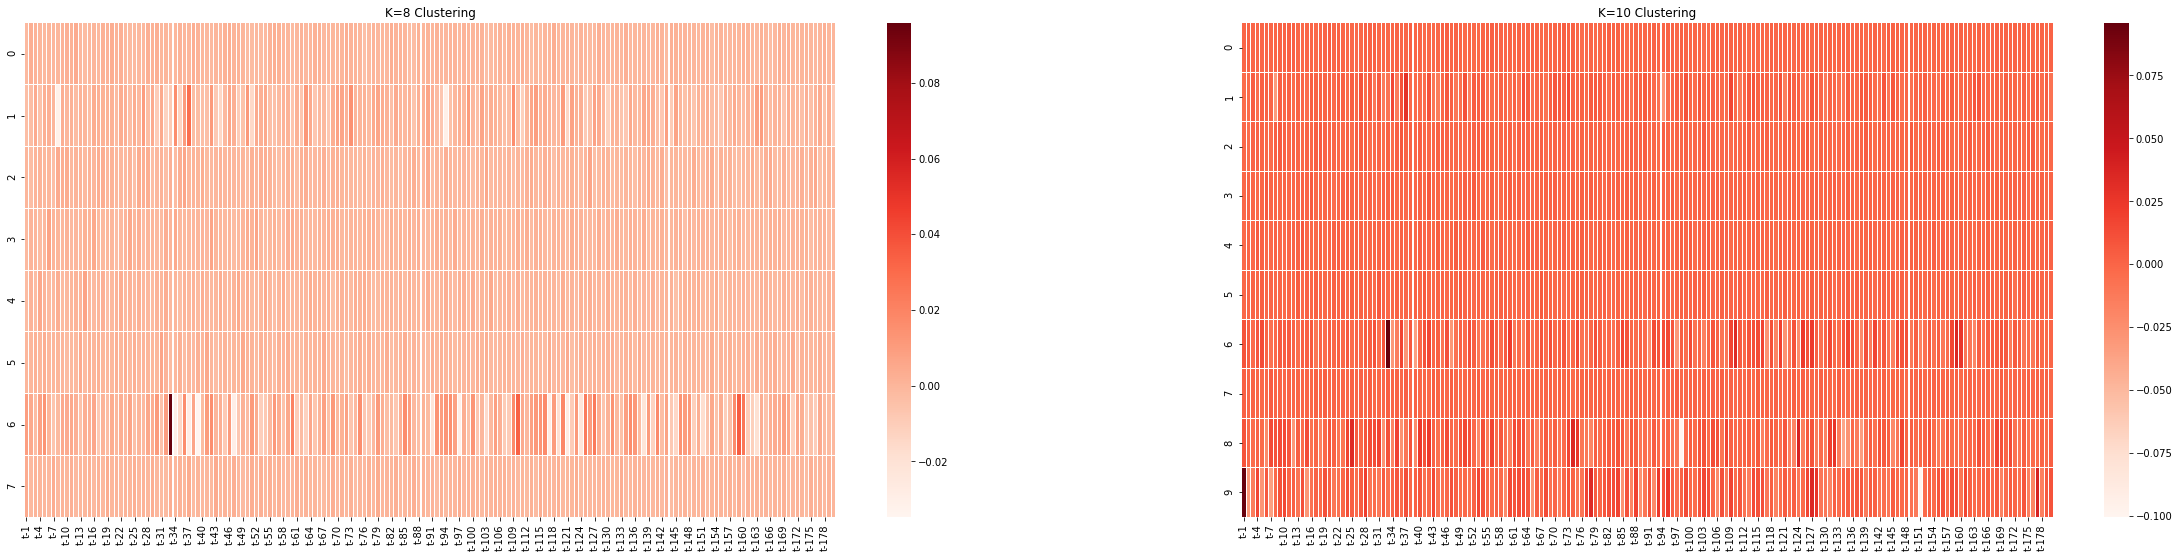

In [15]:
plt.figure(figsize=(40,20))

plt.subplot(2,3,1)
plt.title("K=2 Clustering")
sns.heatmap(summary_2.drop(columns=['Cluster', 'Count']), cmap='Reds', linewidths=0.01)

plt.subplot(2,3,2)
plt.title("K=4 Clustering")
sns.heatmap(summary_4.drop(columns=['Cluster', 'Count']), cmap='Reds', linewidths=0.01)

plt.subplot(2,3,3)
plt.title("K=6 Clustering")
sns.heatmap(summary_6.drop(columns=['Cluster', 'Count']), cmap='Reds', linewidths=0.01)
plt.show()

plt.figure(figsize=(40,20))
plt.subplot(2,2,1)
plt.title("K=8 Clustering")
sns.heatmap(summary_8.drop(columns=['Cluster', 'Count']), cmap='Reds', linewidths=0.01)

plt.subplot(2,2,2)
plt.title("K=10 Clustering")
sns.heatmap(summary_10.drop(columns=['Cluster', 'Count']), cmap='Reds', linewidths=0.01)
plt.show()